In [12]:
import os
import glob
import pickle as pk
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import randint

from tqdm.notebook import tqdm
from nilearn.image import load_img
from nilearn.masking import apply_mask, unmask
from nibabel import save
from delphi import mni_template
from delphi.utils.tools import z_transform_volume, z_transform

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.decomposition import IncrementalPCA

import matplotlib.pyplot as plt

seed = 2020

In [2]:
class_labels = [["motor-w-rest", "footleft", "footright", "handleft", "handright", "tongue", "rest_MOTOR"],
                ["motor-wo-rest", "footleft", "footright", "handleft", "handright", "tongue"],
                ["wm-w-rest", "body", "face", "place", "tool","rest_WM"],
                ["wm-wo-rest", "body", "face", "place", "tool"],
                ["relation-w-rest", "match", "relation", "rest_RELATIONAL"],
                ["relation-wo-rest", "match", "relation"],
                ["social-w-rest", "mental", "rnd", "rest_SOCIAL"],
                ["social-wo-rest", "mental", "rnd"],
                ["multi-w-rest", "footleft", "footright", "handleft", "handright", "tongue", "rest_MOTOR",
                "body", "face", "place", "tool", "rest_WM",
                "match", "relation", "rest_RELATIONAL",
                "mental", "rnd", "rest_SOCIAL"],
                ["multi-wo-rest", "footleft", "footright", "handleft", "handright", "tongue",
                "body", "face", "place", "tool",
                "match", "relation",
                "mental", "rnd"]
               ]


In [3]:
pca_save_dir = os.path.join('./pca_models')
if not os.path.exists(pca_save_dir):
    os.mkdir(pca_save_dir)
svm_save_dir = os.path.join('./svm_models')
if not os.path.exists(svm_save_dir):
    os.mkdir(svm_save_dir)
svm_maps_dir = os.path.join('./svm_maps')
if not os.path.exists(svm_maps_dir):
    os.mkdir(svm_maps_dir)

# FUNCTIONS

In [4]:
def load_data(n, data_dir, classes, split, brain_mask=None):
    
    for i, label in tqdm(enumerate(classes), desc="class"):
        file_list = glob.glob(os.path.join(data_dir, split, label, 'sub*.nii.gz'))
        file_list = file_list[:n]
        if i == 0:
            data = apply_mask(load_img(file_list), brain_mask)
        else:
            data = np.vstack((data, apply_mask(load_img(file_list), brain_mask)))
    
    return data
            
def run_pca(data, max_components, batch_size, save_dir="./pca_models", prefix=None, seed=2020):
    """
    IncrementalPCA is helpful for datasets that require large amounts of memory.
    max_components: the number of components you want to keep
    batch_size: how many samples per batch
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_name = os.path.join(save_dir, '%s_seed%d.pkl' % (prefix, seed))

    if os.path.exists(save_name):
        print('%s already exists. Loading instead' % save_name)
        with open(save_name, 'rb') as pickle_file:
            pca = pk.load(pickle_file)
    else:
        pca = IncrementalPCA(n_components=max_components, batch_size=batch_size)
        pca.fit(data)
        print('Saving %s for later use.' % save_name)
        with open(save_name, 'wb') as pickle_file:
            pk.dump(pca, pickle_file)
            
    return pca

def run_svm(data, Y, n_classes, approach="ovr", prefix=None, dims=None, save_dir="./svm_models", seed=seed):
    """
    Create and train a classifier.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    if dims is None:
        dims = data.shape[1]

    save_name = os.path.join(save_dir, "%s_%s_seed%d.pkl" % (
    prefix, approach, seed))

    if os.path.exists(save_name):
        print('%s already exists. Loading instead' % save_name)
        with open(save_name, 'rb') as pickle_file:
            clf = pk.load(pickle_file)
    else:
        # ONE-VS-ONE
        if approach == "ovo":
            clf = OneVsOneClassifier(
                SVC(kernel="linear", probability=True, break_ties=True, random_state=seed)).fit(data[:, :dims], Y)

        # ONE-VS-REST
        elif approach == "ovr":
            clf = OneVsRestClassifier(
                SVC(kernel="linear", probability=True, break_ties=True, random_state=seed)).fit(data[:, :dims], Y)

        with open(save_name, 'wb') as pickle_file:
            pk.dump(clf, pickle_file)
            
    return clf

def save_maps(clf, data, approach, nsubs, dims, prefix=None, invert_pca=False, save_dir="./svm_maps", seed=seed, brain_mask=mni_template):
    """
    Save the weights of the classifier as .nii.gz files. These files represent the "most important" features of the classifier.
    Since the voxel values are usually quite small we first z-transform them to easier threshold the values.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_name = os.path.join(save_dir, "%s_%s_seed%d.nii.gz" % (prefix, approach, seed))
    if os.path.exists(save_name):
        pass
    else:
        print("saving %s" % save_name)
        n_estimators = len(clf.estimators_)
        to_save = np.zeros((n_estimators, data.shape[-1]))

        if not os.path.exists(save_name):
            for i in range(n_estimators):
                if not invert_pca:
                    to_save[i] = clf.estimators_[i].coef_
                else:
                    to_save[i] = np.dot(clf.estimators_[i].coef_, pca.components_[:dims])
        
        mu = to_save.mean(axis=1)
        mu = mu[:, np.newaxis]
        std = to_save.std(axis=1)
        std = std[:, np.newaxis]
        with np.errstate(divide='ignore'):
            z_transformed = (to_save - mu) / std
        img = unmask(z_transformed, brain_mask)
        save(img, save_name)

def predict(clf, data, Y, dims=None):
    """
    Use the trained classifier to predict the class of the input.
    """

    if dims is None:
        dims = data.shape[1]

    preds = clf.predict(data[:, :dims])
    accs = (np.sum(Y == preds) / len(Y))

    return preds, accs

In [5]:
# let's use different Ns for training and see how the classification performance changes with increasing sample sizes.
n_samples = 160 #[1, 10, 25, 50, 75, 120]
n_folds = 8
accs = np.zeros((n_folds, n_samples, 3))

# does smoothing affect classification performance?
data_dir = "../v-maps/" #["../v-maps/"]# ["../t-maps", "../t-smoothed"]

In [6]:
for c, part in enumerate(class_labels):
    name = part[0]
    lbls = part[1:]
    print(name, lbls, len(lbls))

motor-w-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue', 'rest_MOTOR'] 6
motor-wo-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue'] 5
wm-w-rest ['body', 'face', 'place', 'tool', 'rest_WM'] 5
wm-wo-rest ['body', 'face', 'place', 'tool'] 4
relation-w-rest ['match', 'relation', 'rest_RELATIONAL'] 3
relation-wo-rest ['match', 'relation'] 2
social-w-rest ['mental', 'rnd', 'rest_SOCIAL'] 3
social-wo-rest ['mental', 'rnd'] 2
multi-w-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue', 'rest_MOTOR', 'body', 'face', 'place', 'tool', 'rest_WM', 'match', 'relation', 'rest_RELATIONAL', 'mental', 'rnd', 'rest_SOCIAL'] 17
multi-wo-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue', 'body', 'face', 'place', 'tool', 'match', 'relation', 'mental', 'rnd'] 13


In [7]:
df_train = pd.DataFrame(columns=["n_samples", "acc", "condition"])
df_valid = pd.DataFrame(columns=["n_samples", "acc", "condition"])
df_test = pd.DataFrame(columns=["n_samples", "acc", "condition"])

for c, part in enumerate(class_labels):
    name = part[0]
    lbls = part[1:]
    n_classes = len(lbls)
    print(name, lbls)
        
    train_data = load_data(n_samples, data_dir, lbls, "train", brain_mask=mni_template)
    train_lbls = np.repeat(np.arange(n_classes), n_samples)
    test_data = load_data(40, data_dir, lbls, "test", brain_mask=mni_template)
    test_lbls = np.repeat(np.arange(n_classes), 40)

    sss = StratifiedKFold(n_splits=n_folds)
    idx_train, idx_valid = next(sss.split(train_data, train_lbls))
    fold = 0
    # train classifier for the first fold
    # assign a unique seed for each folds pca and svm
    this_seed = 2020 + fold

    maps = os.path.join(svm_maps_dir)
    pcas = os.path.join(pca_save_dir)
    svms = os.path.join(svm_save_dir)

    # select the respective data for the training and validation data/labels
    this_train_data, this_valid_data = train_data[idx_train, :], train_data[idx_valid, :]
    this_train_lbls, this_valid_lbls = train_lbls[idx_train], train_lbls[idx_valid]

    # run a PCA on the training data
    print('Running PCA on training data...')
    max_components = min(this_train_data.shape)
    pca = run_pca(this_train_data, max_components, batch_size=max_components//10, prefix=name, seed=this_seed, save_dir=pcas)

    # transform the training and validation data data
    print('Transforming the input data...')
    train_transformed = pca.transform(this_train_data)
    valid_transformed = pca.transform(this_valid_data)
    test_transformed = pca.transform(test_data)

    # run SVM
    print('Running SVM...')
    clf = run_svm(train_transformed, this_train_lbls, n_classes, approach="ovr", prefix=name, save_dir=svms)

    # performance on train set
    train_predicted, acc = predict(clf, train_transformed, this_train_lbls, train_transformed.shape[1])
    df_train = pd.concat([df_train, pd.DataFrame({"n_samples": n_samples, "acc": acc, "condition": name}, index=[fold])])

    # performance on validation set
    valid_predicted, acc = predict(clf, valid_transformed, this_valid_lbls, valid_transformed.shape[1])
    df_valid = pd.concat([df_valid, pd.DataFrame({"n_samples": n_samples, "acc": acc, "condition": name}, index=[fold])])

    # performance on test set
    test_predicted, acc = predict(clf, test_transformed, test_lbls, test_transformed.shape[1])
    df_test = pd.concat([df_test, pd.DataFrame({"n_samples": n_samples, "acc": acc, "condition": name}, index=[fold])])

    save_maps(clf, test_data, 'ovr', n_samples, test_transformed.shape[1], invert_pca=True, prefix=name, save_dir=maps)
    # print("%1.4f accuracy" % accs[i])
    
df_train.to_csv(f"./stats/svm_train_acc.csv", index=False)
df_valid.to_csv(f"./stats/svm_valid_acc.csv", index=False)
df_test.to_csv(f"./stats/svm_test_acc.csv", index=False)

motor-w-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue', 'rest_MOTOR']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...
./pca_models\motor-w-rest_seed2020.pkl already exists. Loading instead
Transforming the input data...
Running SVM...
saving ./svm_maps\motor-w-rest_ovr_seed2020.nii.gz
motor-wo-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\motor-wo-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\motor-wo-rest_ovr_seed2020.nii.gz
wm-w-rest ['body', 'face', 'place', 'tool', 'rest_WM']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\wm-w-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\wm-w-rest_ovr_seed2020.nii.gz
wm-wo-rest ['body', 'face', 'place', 'tool']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\wm-wo-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\wm-wo-rest_ovr_seed2020.nii.gz
relation-w-rest ['match', 'relation', 'rest_RELATIONAL']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\relation-w-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\relation-w-rest_ovr_seed2020.nii.gz
relation-wo-rest ['match', 'relation']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\relation-wo-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\relation-wo-rest_ovr_seed2020.nii.gz
social-w-rest ['mental', 'rnd', 'rest_SOCIAL']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\social-w-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\social-w-rest_ovr_seed2020.nii.gz
social-wo-rest ['mental', 'rnd']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\social-wo-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\social-wo-rest_ovr_seed2020.nii.gz
multi-w-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue', 'rest_MOTOR', 'body', 'face', 'place', 'tool', 'rest_WM', 'match', 'relation', 'rest_RELATIONAL', 'mental', 'rnd', 'rest_SOCIAL']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\multi-w-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\multi-w-rest_ovr_seed2020.nii.gz
multi-wo-rest ['footleft', 'footright', 'handleft', 'handright', 'tongue', 'body', 'face', 'place', 'tool', 'match', 'relation', 'mental', 'rnd']


class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...


C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
C:\Users\Philipp\anaconda3\envs\fmrideep\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Saving ./pca_models\multi-wo-rest_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps\multi-wo-rest_ovr_seed2020.nii.gz


# plot the test accuracies

In [20]:
["w/ rest", "w/o rest"]*5

['w/ rest',
 'w/o rest',
 'w/ rest',
 'w/o rest',
 'w/ rest',
 'w/o rest',
 'w/ rest',
 'w/o rest',
 'w/ rest',
 'w/o rest']

In [24]:
df = pd.read_csv("stats/svm_test_acc.csv")
df["a"] = ["w/ rest", "w/o rest"]*5
df["b"] = ["motor", "motor", "wm", "wm", "relation", "relation", "social", "social", "multi", "multi"]

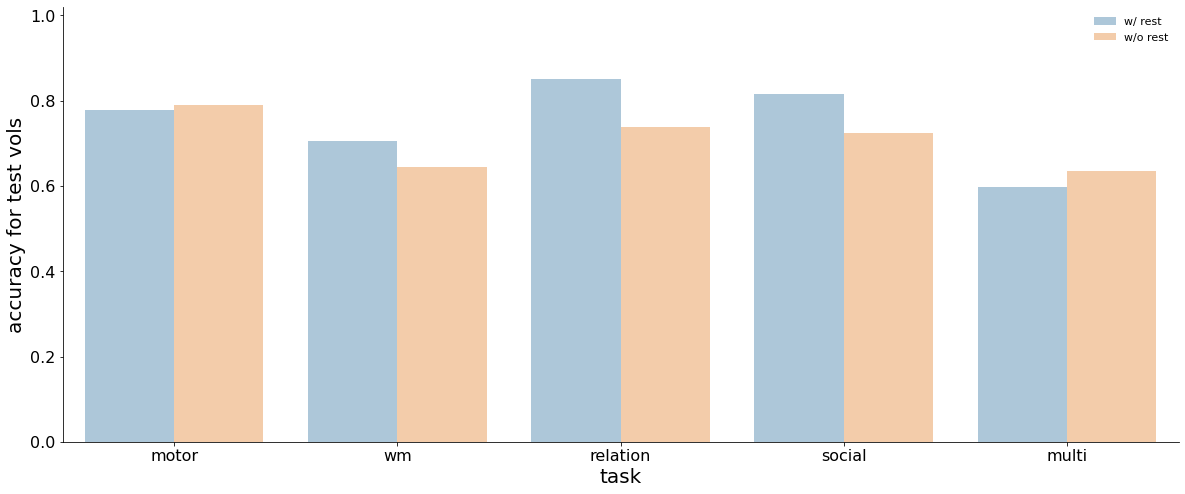

In [28]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axes = plt.subplots(figsize=(20, 8))

# left plot is for the motor data only
sns.barplot(ax=axes, data=df, x="b", y="acc", hue="a", alpha=.4, zorder=1)

axes.spines[["right", "top"]].set_visible(False)
axes.set(ylim=[0, 1.02], ylabel="accuracy for test vols", xlabel="task");
axes.legend(frameon=False, fontsize=11)

#plt.savefig('figures/motor-accs-across-folds-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

# ROC curves

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from delphi.utils.plots import confusion_matrix

train_lbls = np.repeat(np.arange(n_classes), 140)
test_lbls = np.repeat(np.arange(n_classes), 20)
test_data = load_data(20, "../t-maps/", class_labels, "test", brain_mask=mni_template)


label_binarizer = LabelBinarizer().fit(train_lbls)
y_onehot_test = label_binarizer.transform(test_lbls)
y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
f = 1

svm_files = load_img(f"../00_svm/svm_maps/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.nii.gz")
pca_file = f"../00_svm/pca_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_2280samples_seed{2020+f}.pkl"
with open(pca_file, 'rb') as pickle_file:
    pca = pk.load(pickle_file)

svm_file = f"../00_svm/svm_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.pkl"
with open(svm_file, 'rb') as pickle_file:
    svm = pk.load(pickle_file)
    
test_transformed = pca.transform(test_data)
y_predicted, acc = predict(svm, test_transformed, test_lbls, test_transformed.shape[1])
y_score = svm.predict_proba(test_transformed)

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(10, 10))

conf_mat, conf_ax = confusion_matrix(test_lbls, y_predicted, class_labels, normalize=False, ax=ax, **{"vmin": 0, "vmax": 20})
fig.tight_layout()
plt.savefig('figures/confmat-fold01-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, f1_score

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc  = dict(), dict(), dict()
f1_test = np.zeros(n_classes)
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

# F1-score
f1 = dict()
f1['micro'] = f1_score(test_lbls, y_predicted, average="micro")
f1['macro'] = f1_score(test_lbls, y_predicted, average="macro")

print(f"Micro-averaged F1: {f1['micro']}; Macro-averaged F1: {f1['macro']}")

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    idc = np.where(test_lbls==i)
    f1_test[i] = f1_score(test_lbls[idc], y_predicted[idc], average="micro")
    #print(f"F1 for {class_labels[i]}: {f1_test[i]}")
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(n_classes), f1_test, color=[.6,.6,.6])
ax.axhline(f1['micro'], linestyle="--", color="deeppink", label="micro-average", linewidth=2)
ax.set_xticks(np.arange(n_classes))
ax.set_xticklabels(class_labels, rotation=45);
ax.spines[["top", "right"]].set_visible(False);
ax.set_title("F1 score per class");
ax.set(ylabel="F1-score")
ax.legend(frameon=False, fontsize=11)

plt.savefig('figures/F1-fold01-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
from itertools import cycle
from matplotlib import cm

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(12, 12))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cm.get_cmap("jet", 19)
for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_labels[class_id]}",
        color=colors(class_id)[:3],
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC One-vs-Rest")
ax.legend(frameon=False, fontsize=11)

plt.savefig('figures/ROC-fold01-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

## Test OVO ROC

In [ ]:
class_labels

In [ ]:
from itertools import combinations

pair_list = list(combinations(np.unique([5, 6, 9, 12]), 2))
#pair_list = list(combinations(np.unique(test_lbls), 2))
print(len(pair_list))

In [ ]:
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = test_lbls == label_a
    b_mask = test_lbls == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_labels[idx_a]} vs {class_labels[idx_b]} ROC curves")
    plt.legend()
    #plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

# PRECISION RECALL CURVE

In [ ]:
from sklearn.metrics import precision_recall_curve

task_names = ["motor", "gambling", "social", "wm", "relational", "emotion", "language"]
class_per_task =[["footleft", "footright", "handleft", "handright", "tongue"], 
                ["loss", "reward"], 
                ["mental", "random"], 
                ["body", "face", "place", "tool"], 
                ["match", "relation"], 
                ["emotion", "neut"], 
                ["story", "math"]]

linestyle_tuple = [
     ('solid', (0, ())),
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)))]

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(2, 4, figsize=(30, 15), sharex=True, sharey=True)

ax = ax.flatten()
ax[-1].set_visible(False)
ctr = 0
# precision recall curve
for i, task in enumerate(class_per_task):
    #print(task)
    precision, recall = dict(), dict()
    for j, cl in enumerate(task):
        precision[j], recall[j], _ = precision_recall_curve(y_onehot_test[:, ctr],
                                                            y_score[:, ctr])
        ax[i].plot(recall[j], precision[j], lw=2, linestyle=linestyle_tuple[j][1], label='{}'.format(cl))
        ctr += 1
    
    ax[i].set_xlabel("recall")
    ax[i].set_ylabel("precision")
    ax[i].set_title(task_names[i])
    ax[i].legend(frameon=False, fontsize=14, title="classes")
    
#plt.savefig(f'figures/PR-fold01.pdf', facecolor=fig.get_facecolor(), transparent=True)

# MUTUAL INFORMATION WITH ORIGINAL DATA

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from nilearn.masking import apply_mask
from nilearn.image import load_img

from delphi import mni_template

class_labels = ["footleft", "footright", "handleft", "handright", "tongue", 
                "loss", "reward", 
                "mental", "random", 
                "body", "face", "place", "tool", 
                "match", "relation", 
                "emotion", "neut", 
                "story", "math"]

In [ ]:
# load the group t-statistic maps
mask = load_img(mni_template)
t_group = load_img(glob.glob("../03_full_hcp/stat-maps/orig/SS3/*.nii.gz"))
t_group = apply_mask(t_group, mask)

svm_maps = load_img("svm_maps/nsubs-120/k-fold_ss-3mm_fold01_ovr_120subs_2280dims_seed2020.nii.gz")
svm_maps = apply_mask(svm_maps, mask)

In [ ]:
# since we use a linear svm let's see how similar the brain maps are using correlation - vs mutual information
rho = np.zeros(19)
for i in range(19):
    a = svm_maps[i]
    b = t_group[i]

    rho[i] = np.corrcoef(a.squeeze(), b.squeeze())[0,1]
    
df_rho = pd.DataFrame({'values': rho.tolist(),'class': class_labels, 'fold': 1, 'attr_method': 'svm', 'contrast': 'grpattr-vs-grpt', 'measure': 'pearsons_r'})
df_rho
#df_rho.to_csv("stats/rho_grpattr-vs-grpt.csv", index=False)

In [ ]:
mi = np.zeros(19)
for i in range(19):
    mi[i] = mutual_info_regression(X=svm_maps[i, :].reshape(-1, 1), y=t_group[i, :], discrete_features=False, random_state=2020)

df_mi = pd.DataFrame({'values': mi.tolist(),'class': class_labels, 'fold': 0, 'attr_method': 'svm', 'contrast': 'grpattr-vs-grpt', 'measure': 'mi'})
#df_mi.to_csv("mi_grpattr-vs-grpt.csv", index=False)

In [ ]:
df_mi = df_mi.rename(columns={'mi': 'measure'})
df_rho = df_rho.rename(columns={'pearsons_r': 'measure'})

df2 = pd.concat([df_mi, df_rho])

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(ax=ax, data=df2, x="class", y="values", hue="measure")
ax.set_xticklabels(class_labels, rotation=45);
ax.set_ylabel("$MI_{(SVM, GroupT)}$")
ax.spines[["top", "right"]].set_visible(False)
#plt.savefig(f'figures/shared-info.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
mutual_info_regression(X=svm_maps[i, :].reshape(-1, 1), y=t_group[i, :], discrete_features=False, random_state=2020)